In [1]:
from scipy.integrate import odeint
import numpy as np
from ode_api import *
from ode_funcs import *
import matplotlib.pyplot as plt
import scipy
import pymc3 as pm

In [ ]:
#odefunc, n_states, n_ivs, n_odeparams, y0 = None

n_states = 2
n_ivs = 2
n_odeparams = 1

times = np.arange(0,5,0.25)

model = ODEModel(odefunc = test_ode_func_3, 
                    times = times,
                    n_states = n_states,
                    n_ivs = n_ivs,
                    n_odeparams = n_odeparams)





sims, sens = model.simulate([8,0.99,0.01])
S = scipy.stats.lognorm.rvs(s = 0.1, scale = sims[:,0])
I = scipy.stats.lognorm.rvs(s = 0.1, scale = sims[:,1])

# Define the data matrix
Y = np.vstack((S,I)).T

In [ ]:
# Now instantiate the theano custom ODE op
my_ODEop = ODEop(model)

In [ ]:
# The probabilistic model
with pm.Model() as LV_model:

    # Priors for unknown model parameters
    beta = pm.Normal('beta',6,2)
    # S0 = pm.Deterministic('S0',0.99)
    # I0 = pm.Deterministic('I0',0.01)
    
    sigma = pm.HalfCauchy('sigma',1)

    # Forward model
    all_params = pm.math.stack([beta, 0.99,0.01],axis=0)
    ode_sol = my_ODEop(all_params)
    forward = ode_sol.reshape(Y.shape)

    # Likelihood 
    Y_obs = pm.Lognormal('Y_obs', mu=pm.math.log(forward), sd=sigma, observed=Y)
    
    trace = pm.sample(1500, tune=1000, init='adapt_diag')

pm.traceplot(trace)

plt.show()

In [5]:
n_states = 1
n_ivs = 1
n_odeparams = 1

times = np.arange(0.5,12, 0.5)

model = ODEModel(odefunc = test_ode_func_1, 
                    times = times,
                    n_states = n_states,
                    n_ivs = n_ivs,
                    n_odeparams = n_odeparams)



sims, sens = model.simulate([0.5,0])

Y=sims+ np.random.normal(0,0.01, size = sims.shape)
Y= Y.ravel()

an_ODEop = ODEop(model)






AsTensorError: ('Cannot convert (n, m) to TensorType', <class 'tuple'>)

In [3]:
# The probabilistic model
with pm.Model() as LV_model:

    # Priors for unknown model parameters
    alpha = pm.HalfNormal('alpha', sd = 0.5)
    
    sigma = pm.HalfCauchy('sigma',1)

    # Forward model
    all_params = pm.math.stack([alpha, 0],axis=0)
    ode_sol = an_ODEop(all_params)
    forward = ode_sol.reshape(Y.shape)

    # Likelihood 
    Y_obs = pm.Lognormal('Y_obs', mu=pm.math.log(forward), sd=sigma, observed=Y)
    
    trace = pm.sample(1500, tune=1000, init='adapt_diag', target_accept = 0.99)

pm.traceplot(trace)

plt.show()

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha]
Sampling 4 chains:   0%|          | 0/10000 [00:00<?, ?draws/s]


RuntimeError: Chain 0 failed.

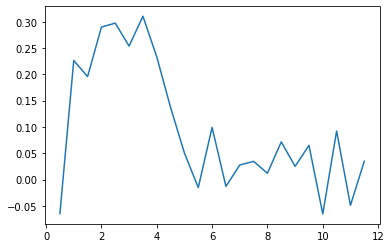

In [4]:
plt.plot(times,Y)

In [ ]:
with LV_model:
    yppc = pm.sample_ppc(trace)

In [ ]:
y = yppc['Y_obs']
plt.fill_between(times, np.percentile(y, 2.5, axis = 0), np.percentile(y, 97.5, axis = 0), alpha = 0.5)
plt.plot(times,yppc['Y_obs'].mean(axis = 0))